Importing the required libraries for the project.

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import (LinearRegression, Ridge, Lasso)
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (MinMaxScaler, PolynomialFeatures)
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Importing the King County Dataset from local filepath

In [4]:
data = pd.read_csv("home_price.csv")

In [5]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Data Pre-Processing

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015. We have multiple variable like date, longitude, latitude which don't contribute to the model. Additonally we have variable from which we can gain use insight through aggregation. Let initiate the data preprocessing stage through looking at the variable types.

In [6]:
print(data.dtypes)

id                 int64
date              object
price              int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


The date field by itself does'nt provide any valuable insight into any statistical model. Substracting the date of built can help in gaining insight, as the price of any house is directly proportional to the age of the house.

In [7]:
#Extract data year from date field
data.date = pd.to_datetime(data.date)
data['data_year'] = data['date'].dt.year

# Set renovation year to built year where renovation didn't take place
data['yr_renovated'][data['yr_renovated']==0] = data['yr_built'][data['yr_renovated']==0]

data['yrs_since_built'] = data['data_year']-data['yr_built']
data['yrs_since_renovated'] = data['data_year']-data['yr_renovated']

The longitude and latitude of the house location is less value until and unless is compared to central location wherein the house prices are maximum.

In [8]:
data[['long','lat']][data['price'] == max(data['price'])]

,long,lat
7252,-122.323,47.6298


We expected this high price near this longitude and latitude as it is closer to the capital city, Seattle. Based on our analogy, finding an euclidean distance between the the capital and housing location can be significant factor to our model.

In [9]:
#Taking seattle as the centre point
#Source:map.google.com

seattle = np.array([[47.6131746,-122.4821478]],dtype="float64")

loc = np.array(data[['lat','long']])

from scipy.spatial import distance

dist = []

for i in np.arange(len(loc)):
    dist.append(round(distance.euclidean(loc[i],seattle),2))

data['dist'] = dist

As we can see there are multiple columns which are not contributing to the models. Let proceed with droping these columns to get our optimal set of variables for exploratory analysis.

In [10]:
data = data.drop(['id','date','lat','long','yr_built','yr_renovated','data_year'],axis=1)

Dividing the data into training and test data.

In [11]:
y = data['price']
X = data.drop('price',axis=1)

# Create train and test sets before adding zip code average price
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

The zipcode variable is also an uninformative variable which contributes less to the overall model. Based on our intuition, we have group the zip codes and deduced an average house price in the area which can be a contributing factor. Based on the training data we can deduce the average housing price near in a zipcode.

In [12]:
def zipcodeavg(X,y):
    temp = pd.concat([X,y],axis=1)
    grouped = temp.groupby('zipcode').agg({'price':'mean'})
    grouped = grouped.reset_index(level = 'zipcode')
    temp = pd.merge(X,grouped,how='left',on='zipcode')
    temp.rename(columns={'price':'zipcodeavgprice'},inplace=True)
    map = temp.groupby(['zipcode','zipcodeavgprice']).size().reset_index().rename(columns={0:'count'})
    del temp['zipcode']
    del map['count']
    return temp,map

#Calling the function to add the zipcodeavg X_train    
X_train,map = zipcodeavg(X_train,y_train)

#Using train data to map avg zipcode price to X_test
X_test  = pd.merge(X_test,map,on='zipcode',how='left')
X_test = X_test.drop('zipcode',axis=1)     

Our final dataset can be deduced with the following variables.

In [13]:
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,yrs_since_built,yrs_since_renovated,dist,zipcodeavgprice
0,4,2.50,2680,4499,2.0,0,0,3,9,2680,0,2920,4500,16,16,0.36,881034
1,4,1.75,2340,5080,1.0,0,0,5,7,1170,1170,1270,3270,90,90,0.17,621966
2,4,2.25,2190,9020,2.0,0,0,3,8,2190,0,2170,8400,36,36,0.31,246208
3,2,1.75,2260,280962,2.0,0,2,3,9,1890,370,2860,219542,9,9,0.54,441349
4,4,1.75,2110,265716,1.0,0,0,4,8,2110,0,2110,110597,35,35,0.46,662192


### Exploratory Analysis

We have mulitple sets of variable which can be used to deduce the house price. Based on the pattern, we expect multiple correlation between our variables and possible correlation to our error term leading to hetroskedacity. Let's explore the data by drawing a correlation plot between our variables.

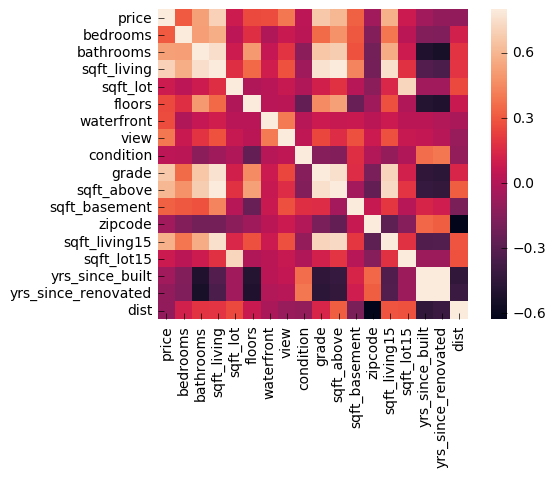

In [14]:
correlation_mat = data.corr()
sns.heatmap(correlation_mat, vmax=.8, square=True);

Based on the corelation plot, we see strong correlation between the price (target variable) with the variables sqft_living, grade, sqft_above, view and bathrooms. Lets check the relation between them through a details correlation plot.

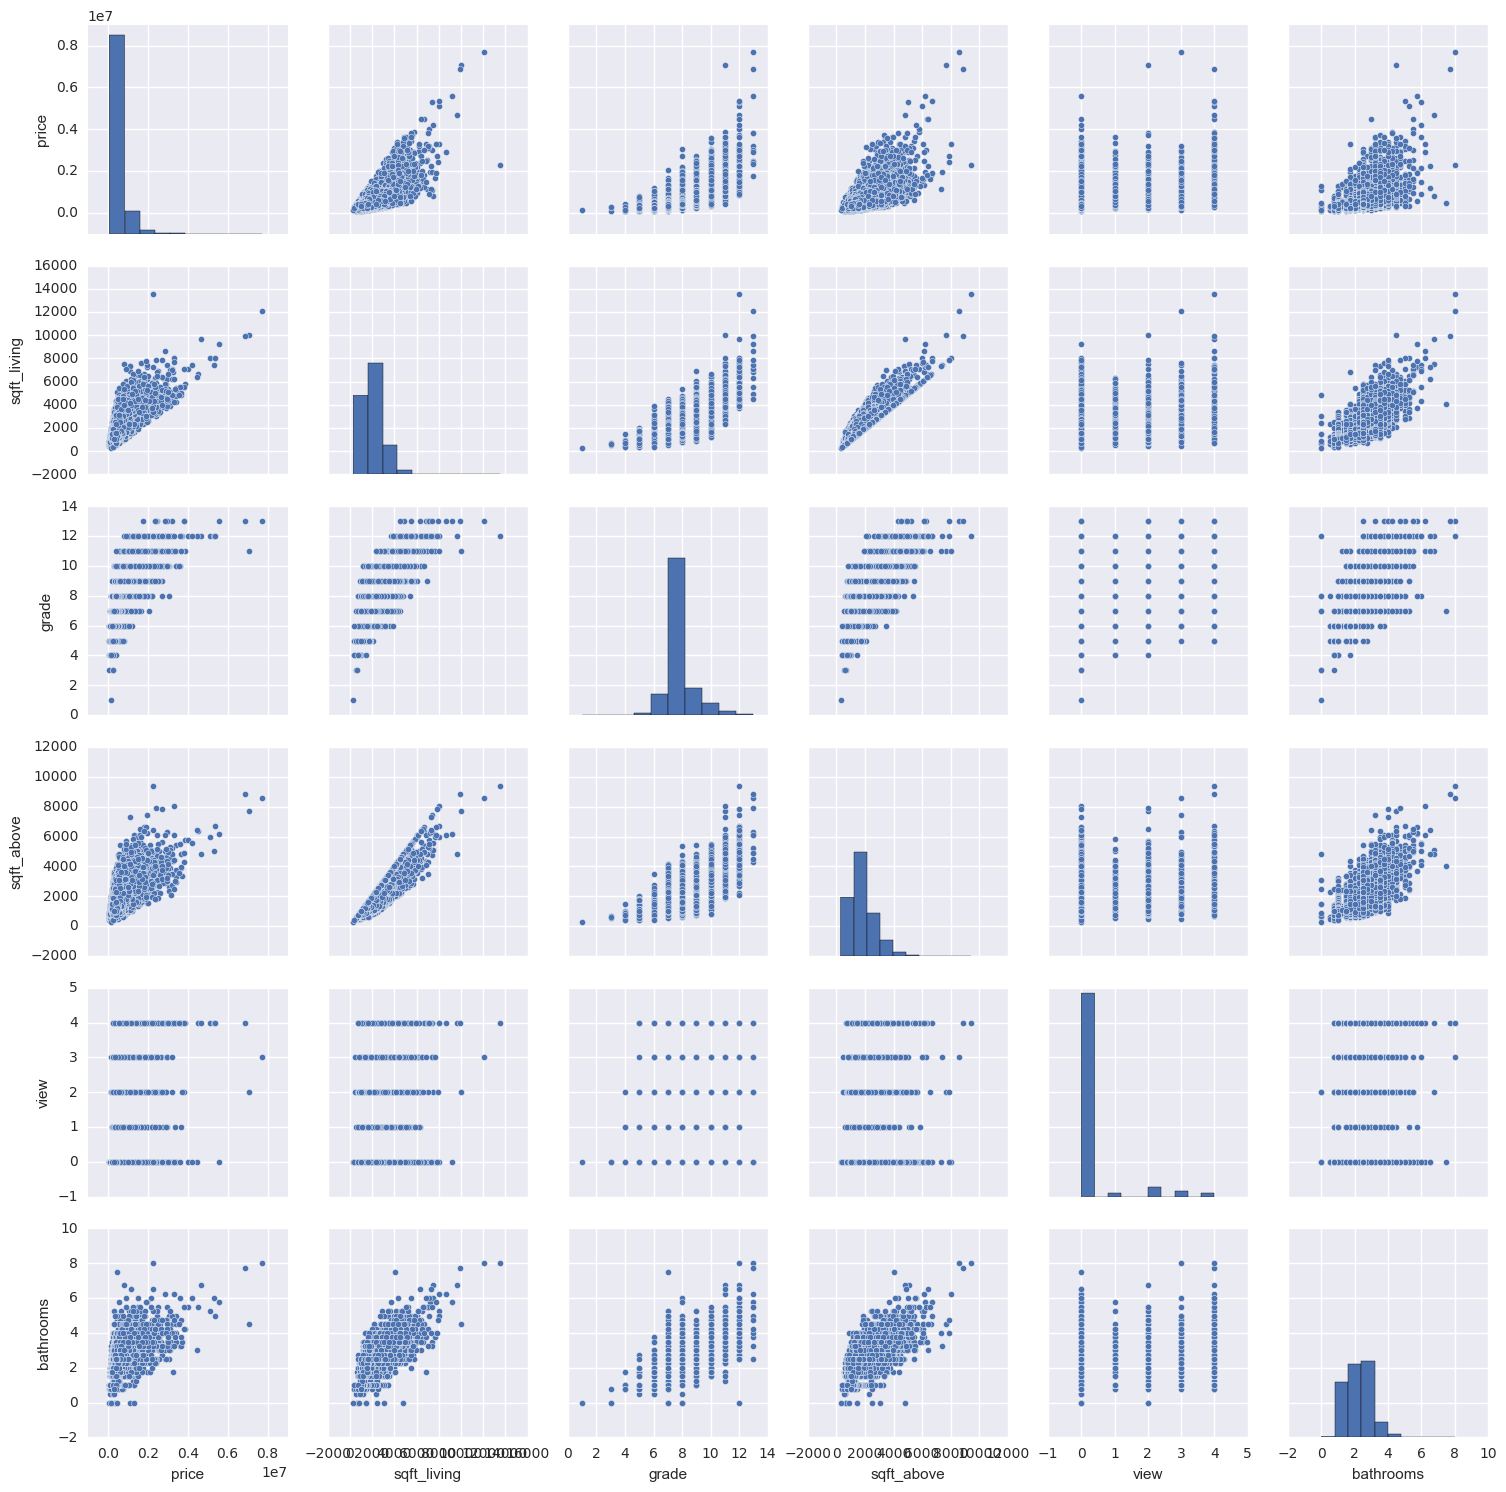

In [15]:
corr_mat = X_train.corr()
sns.set()
cols = ['price', 'sqft_living', 'grade', 'sqft_above', 'view', 'bathrooms']
sns.pairplot(data[cols], size = 2.5)
plt.show()

### Part 1

### Multiple Linear Regression

In [137]:
linreg = LinearRegression().fit(X_train, y_train)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

linear model coeff (w): [ -2.87312813e+04   3.15697777e+04   1.12968961e+02   2.84820779e-01
  -2.30241069e+04   5.68611694e+05   5.57185651e+04   1.48030253e+04
   5.77475904e+04   9.10780490e+01   2.18909118e+01  -1.71153108e+01
  -1.53214724e-01   1.63471057e+03  -3.68580747e+02  -3.11337103e+05
   6.20935166e-01]
linear model intercept (b): -572694.679
R-squared score (training): 0.790
R-squared score (test): 0.788


### Part 2

Let's plot the polynomial regression relation between the price and variables which we found correlated in our exploratory analysis.

'price', 'sqft_living', 'grade', 'sqft_above', 'view', 'bathrooms'

In [27]:
# Need to draw plots

Use a polynomial regression as a mean to examine this dataset. Let's validate the degree of the polynomial through tuning through the training set.

In [24]:
poly_df = pd.DataFrame(np.arange(2,5),columns=['degree'])

train_sc = []
test_sc = []
for i in np.arange(2,5):
    poly = PolynomialFeatures(degree=i)
    X_F1_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    linreg = LinearRegression().fit(X_F1_poly, y_train)
    train_sc.append(linreg.score(X_F1_poly,y_train))
    test_sc.append(linreg.score(X_test_poly,y_test))

poly_df['training_score'] = train_sc
poly_df['testing_score'] = test_sc

poly_df

,degree,training_score,testing_score
0,2,0.885257,0.867601
1,3,0.909836,-1.734581
2,4,0.922343,-1052.005977


Based on our model the best polynomial order can be chosen as degree = 2. 

### Part 3

Run ridge and Lasso regression multiple times with different L1 and L2 penalties to see which one produces the best fit.

##### Ridge Regression

In [104]:
#%% RIDGE REGRESSION

# Setup the pipeline steps: steps
steps = [('scaler', MinMaxScaler()),
         ('Ridge', Ridge(tol=0.1))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'Ridge__alpha': np.logspace(-4, 0, 50)}


# Create the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(pipeline,param_grid=parameters,cv=5)

# Fit to the training set
gm_cv.fit(X_train,y_train)
    
# Compute and print the metrics
r2 = gm_cv.score(X_test, y_test)
print("Tuned Ridge Alpha: {}".format(gm_cv.best_params_))
print("Tuned Ridge R squared: {0:.4f}".format(r2))

Tuned Ridge Alpha: {'Ridge__alpha': 0.26826957952797248}
Tuned Ridge R squared: 0.7879


##### LASSO Regression

In [ ]:
#%% LASSO REGRESSION

# Setup the pipeline steps: steps
steps = [('scaler', MinMaxScaler()),
         ('Lasso', Lasso(tol=0.1))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'Lasso__alpha': np.logspace(-4, 0, 50)}


# Create the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(pipeline,param_grid=parameters,cv=5)

# Fit to the training set
gm_cv.fit(X_train,y_train)
    
# Compute and print the metrics
r2 = gm_cv.score(X_test, y_test)
print("Tuned Lasso Alpha: {}".format(gm_cv.best_params_))
print("Tuned Lasso R squared: {0:.4f}".format(r2))


#%%Plotting

#%% Custom function

def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()
#%%
# Ridge
scaler = MinMaxScaler()
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True,tol=0.1)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge,X_test_scaled,y_test,cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)
#%%
#Lasso 
scaler = MinMaxScaler()
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
lasso_scores = []
lasso_scores_std = []

# Create a lasso regressor: ridge
lasso = Lasso(normalize=True,tol=0.1)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: lasso.alpha
    lasso.alpha = alpha
    
    # Perform 10-fold CV: lasso_cv_scores
    lasso_cv_scores = cross_val_score(lasso,X_test_scaled,y_test,cv=10)
    
    # Append the mean of lasso_cv_scores to ridge_scores
    lasso_scores.append(np.mean(lasso_cv_scores))
    
    # Append the std of lasso_cv_scores to lasso_scores_std
    lasso_scores_std.append(np.std(lasso_cv_scores))

# Display the plot
display_plot(lasso_scores, lasso_scores_std)

### Part 4

As part of this section we will be testing our data using the K Nearest Neighbor Regresssor. We will iterate the fitting process from 1 to 50 nearest neighbor to tune the model.

In [132]:
from sklearn.neighbors import KNeighborsRegressor

# Training the training set through 1 to 50 nearest neigbor
test_score = []

#Developing the knn calssifier
for n in range(1,51):
    knn = KNeighborsRegressor(n_neighbors = n)
    knn.fit(X_train, y_train)
    test_score.append(knn.score(X_test, y_test))
    
train_result = pd.DataFrame(columns=['neighbors','R_Square'])
train_result['neighbors'] = np.arange(1,51)
train_result['R_Square'] = test_score

train_result.sort_values('R_Square',ascending=False,axis=0,inplace=False).head(5)

,neighbors,R_Square
5,6,0.672134
6,7,0.671647
7,8,0.670346
4,5,0.667393
8,9,0.666998


Plotting the modelling outcome to check the best possible value for the k parameter.

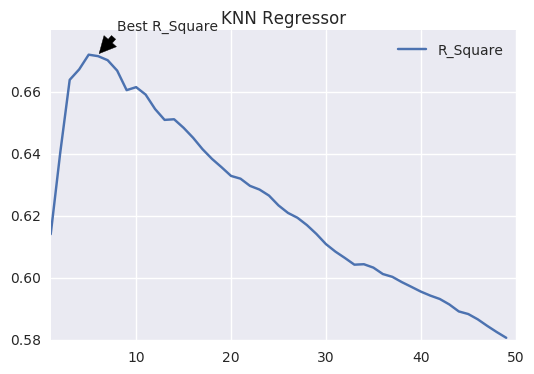

In [135]:
grp = pd.DataFrame(train_result['R_Square'],columns=['R_Square'],index=np.arange(1,51))

grp.plot(title="KNN Regressor")
plt.annotate('Best R_Square', xy=(6,0.672134), xytext=(8, 0.68),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

In [113]:
knnreg = KNeighborsRegressor(n_neighbors = 6).fit(X_train, y_train)

print('R-squared test score: {:.2f}%'
     .format(knnreg.score(X_test, y_test)*100))

R-squared test score: 67.21%
